# **Bike rentle demand prediction**
In this competition/notebook, we are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.. We are given many parameters like weather, time on which the demand of bike depends alot. Because due a slight change in atmosphere the demand may increase or decrease.

This project is just for practice purpose where we are going to apply analysis and various machine learning techniques to get insights and prediction respectively.



### **importing basic libraries**

In [1]:
# for data analysis and manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### **loading data**

In [2]:
train = pd.read_csv('train.csv', parse_dates=['datetime'])
test = pd.read_csv('test.csv', parse_dates=['datetime'])

# display first five line of train set
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Data Fields description :
- **datetime** - hourly date + timestamp  
- **season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- **holiday** - whether the day is considered a holiday
- **workingday** - whether the day is neither a weekend nor holiday
- **weather** - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- **temp** - temperature in Celsius
- **atemp** - "feels like" temperature in Celsius
- **humidity** - relative humidity
- **windspeed** - wind speed
- **casual** - number of non-registered user rentals initiated
- **registered** - number of registered user rentals initiated
- **count** - number of total rentals

Before going onto any analysis and modeling, we would first check whether the data is clean enough or not.

In [3]:
# checking missing values
print('Missing values in training dataset:')
print(train.info())
print('\nMissing values in test dataset:')
print(test.info())

Missing values in training dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB
None

Missing values in test dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492

Okay, so there is no null values in any of the dataset. But, we found a difference in both the dataset is that `casual` and `registered` column is missing in test set. This is because when we add the values of both column, we get the result (count),

    count = casual + registered
so, these features can be used for analysis.

Let's do some analysis, and see what insights we find out.

### **Analysis and exploration**

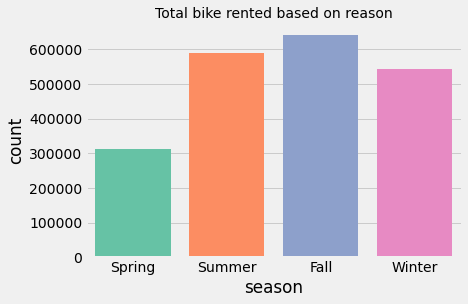

In [4]:
# total rented bike based on season
plt.style.use('fivethirtyeight')
grp_season = train.groupby('season')['count'].sum()
sns.barplot(x=grp_season.index, y=grp_season, palette='Set2', saturation=1)
plt.title('Total bike rented based on reason', fontsize=14)
plt.xticks([0,1,2,3],['Spring','Summer','Fall','Winter']);

Looks like Fall, summer and winter season has higher number of rented bikes and spring has less rented bike compare to these three seasons.

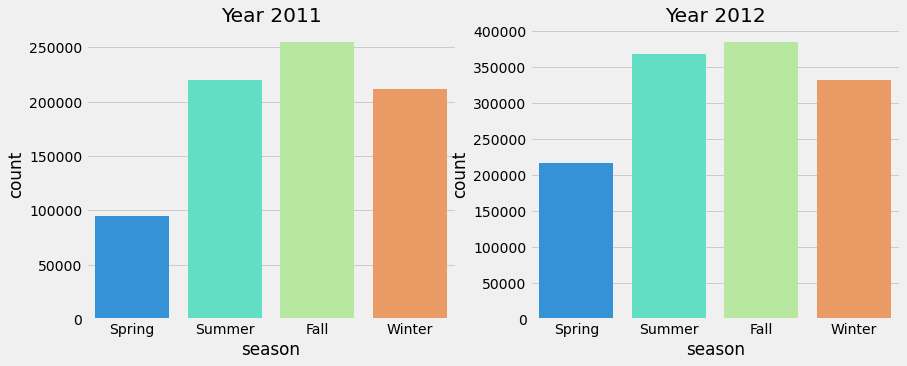

In [5]:
train['year'] = train['datetime'].dt.year
test['year'] = test['datetime'].dt.year
yr_grp = train.groupby('year')
grp_11 = yr_grp.get_group(2011)
grp_12 = yr_grp.get_group(2012)

grp_11_season = grp_11.groupby('season')['count'].sum()
grp_12_season = grp_12.groupby('season')['count'].sum()

fig = plt.figure(figsize=(13,5))
ax1 = fig.add_subplot(1,2,1)
sns.barplot(x=grp_11_season.index, y=grp_11_season, ax=ax1,palette='rainbow')
ax1.set_title('Year 2011')
plt.xticks([0,1,2,3],['Spring','Summer','Fall','Winter'])

ax2 = fig.add_subplot(1,2,2)
sns.barplot(x=grp_12_season.index, y=grp_12_season, ax=ax2, palette='rainbow')
ax2.set_title('Year 2012')
plt.xticks([0,1,2,3],['Spring','Summer','Fall','Winter']);

Definitely, in the year 2012 the number of bike rented in all season is greater than that of year 2011. It may be due to increase in the registered customer.

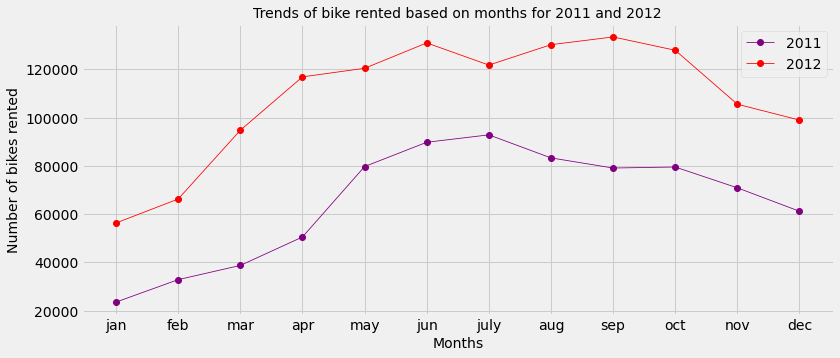

In [6]:
# grouping data by months
grp_11['month'] = grp_11['datetime'].dt.month
grp_11_mnth = grp_11.groupby('month')['count'].sum()

grp_12['month'] = grp_12['datetime'].dt.month
grp_12_mnth = grp_12.groupby('month')['count'].sum()

# adding a new column to train and test data
train['month'] = train['datetime'].dt.month
test['month'] = test['datetime'].dt.month
 
# ploting trends
plt.figure(figsize=(12,5))
plt.plot(grp_11_mnth.index,
         grp_11_mnth,
         marker='o',
         linewidth=0.8,
         c='purple',
         label='2011')
plt.plot(grp_12_mnth.index,
         grp_12_mnth,
         marker='o',
         linewidth=0.8,
         c='red',
         label='2012')

# decorating plots
plt.xlabel('Months', fontsize=14)
plt.ylabel('Number of bikes rented', fontsize=14)
plt.title('Trends of bike rented based on months for 2011 and 2012', fontsize=14)
plt.xticks(range(1,13),['jan','feb','mar','apr','may','jun','july','aug','sep','oct','nov','dec'])
plt.legend();

The data says that people does not take bike on rent in from November to March, however the renting rate is higher in 2012 than in 2011 in all the months. 

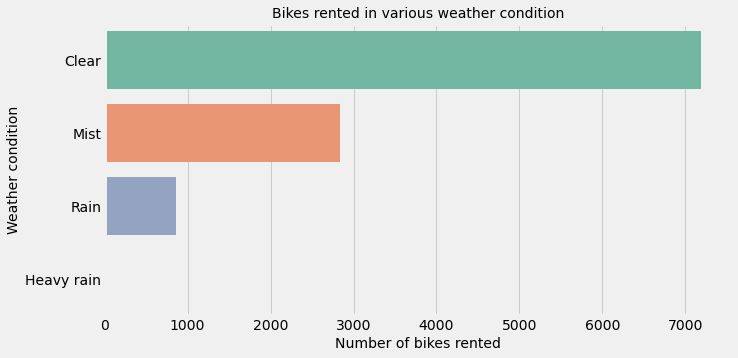

In [7]:
plt.figure(figsize=(10,5))
sns.countplot(y='weather', data=train, palette='Set2')
plt.yticks([0,1,2,3], ['Clear','Mist','Rain','Heavy rain'])
plt.title('Bikes rented in various weather condition', fontsize=14)
plt.ylabel('Weather condition', fontsize=14)
plt.xlabel('Number of bikes rented', fontsize=14);

Approximately, 0% bikes are rented in the heavy rainfall. Whereas, when the weather was clean enough, there were huge amount of bikes rented.

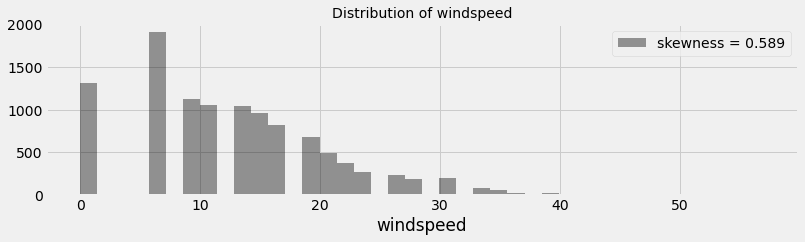

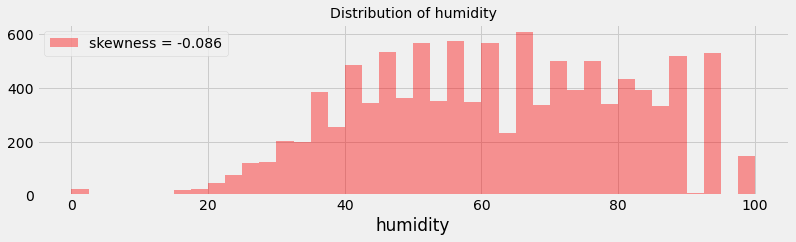

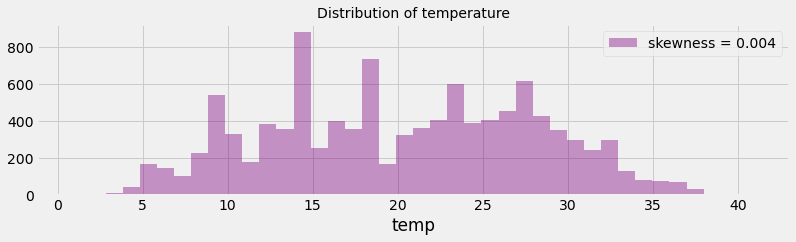

In [8]:
# plot for the distribution of windspeed
plt.figure(figsize=(12,10))
plt.subplot(3,1,1)
sns.distplot(train.windspeed,
             bins=40,
             kde=False, 
             color='black',
             label='skewness = '+str(round(train.windspeed.skew(),3)))
plt.title('Distribution of windspeed', fontsize=14)
plt.legend()

# plot for the distribution of humidity
plt.figure(figsize=(12,10))
plt.subplot(3,1,2)
sns.distplot(train.humidity,
             bins=40,
             kde=False,
             color='red',
             label='skewness = '+str(round(train.humidity.skew(),3)))
plt.title('Distribution of humidity', fontsize=14)
plt.legend()

# plot for the distribution of temperature
plt.figure(figsize=(12,10))
plt.subplot(3,1,3)
sns.distplot(train.temp,
             bins=40, 
             kde=False,
             color='purple', 
             label='skewness = '+str(round(train.temp.skew(),3)))
plt.title('Distribution of temperature', fontsize=14)
plt.legend();

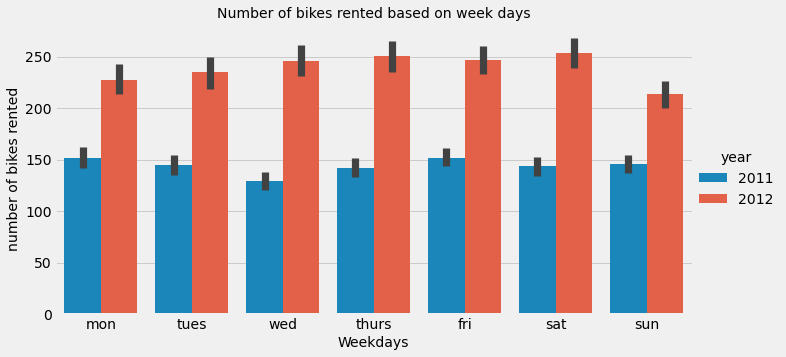

In [9]:
# adding hour column in both dataset
train['hour'] = train['datetime'].dt.hour
test['hour'] = test['datetime'].dt.hour

# adding day column in both dataset
train['day'] = train['datetime'].dt.dayofweek
test['day'] = test['datetime'].dt.dayofweek

# creating a plot for biked rented based on weekdays
sns.factorplot(x='day',
               y='count',
               data=train,
               size=5, 
               aspect=2,
               kind='bar',
               hue='year')

# decorating the plot
plt.title('Number of bikes rented based on week days', fontsize=14)
plt.xlabel('Weekdays', fontsize=14)
plt.ylabel('number of bikes rented', fontsize=14)
plt.xticks(range(0,7), ['mon','tues','wed','thurs','fri','sat','sun']);

Sunday and monday has less number of bikes rented, whereas saturday and thursday has higher number of renting. It is due the weekend, because there is no office work or meeting for people on sunday, so it may be one of the reason.

### **Feature engineering**

In [10]:
# list of nominal features
dummy_feats = ['season','weather','day']

# iterating over each nominal feature to make dummies
for feat in dummy_feats:
    dum_train = pd.get_dummies(train[feat], prefix=feat, drop_first=True)
    dum_test = pd.get_dummies(test[feat], prefix=feat, drop_first=True)
    train = pd.concat([train, dum_train], axis=1)
    test = pd.concat([test, dum_test], axis=1)
    train.drop(feat, axis=1, inplace=True)
    test.drop(feat, axis=1, inplace=True)

# to convert the skewness into normal form 
train['windspeed'] = (train.windspeed)**0.76
test['windspeed'] = (test.windspeed)**0.76

In [11]:
total_features = train.drop(['casual','registered','count','datetime','temp'], axis=1).columns
x = train[total_features]
y = train['count']
test_x = test[total_features]

#### Features selected by RFECV

In [12]:
from sklearn.feature_selection import RFECV, f_regression, SelectKBest, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=349)

# using recursive feature elimination for feature selection
rfe = RFECV(rf, cv=5, step=1)
rfe.fit(x, y)
rfe_select = x.columns[rfe.support_]

# displaying the selected features
rfe_select

Index(['workingday', 'atemp', 'humidity', 'windspeed', 'year', 'month', 'hour',
       'weather_3', 'day_4', 'day_5'],
      dtype='object')

#### Feature selection by SelectKBest

In [13]:
skb = SelectKBest(k=15, score_func=f_regression)
skb.fit(x, y)
freg_df = pd.DataFrame({'features':x.columns,
                        'scores':skb.scores_,
                        'pval':skb.pvalues_}).sort_values('scores', ascending=False)
freg_df

,features,scores,pval
7,hour,2080.571506,0.000000e+00
2,atemp,1949.875122,0.000000e+00
3,humidity,1219.078404,2.921542e-253
5,year,791.729803,3.242017e-168
6,month,311.722553,8.342867e-69
9,season_3,208.008843,1.005975e-46
12,weather_3,152.419684,8.764352e-35
4,windspeed,120.650727,6.385644e-28
8,season_2,62.698524,2.643219e-15
11,weather_2,18.622529,1.607341e-05


In [14]:
skb2 = SelectKBest(k=15, score_func=mutual_info_regression)
skb2.fit(x, y)
mir_df = pd.DataFrame({'features':x.columns,
                        'scores':skb2.scores_}).sort_values('scores', ascending=False)
mir_df

,features,scores
7,hour,0.648628
2,atemp,0.137298
3,humidity,0.098927
6,month,0.088121
5,year,0.050831
9,season_3,0.025187
4,windspeed,0.021393
12,weather_3,0.013690
10,season_4,0.010345
1,workingday,0.006431


In [15]:
mir_feat = mir_df.iloc[0:12]['features'].values.tolist()
freg_feat = freg_df.iloc[0:12]['features'].values.tolist()
rfe_feat = rfe_select.tolist()

In [16]:
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV

# creating function to perform cross validation and grid search
def grid_search(model, x, y, params, cv):
    grid = GridSearchCV(model, 
                        scoring='neg_mean_squared_log_error',
                        param_grid=params,
                        cv=cv,
                        n_jobs=4)
    grid.fit(x, y)
    print('The best parameters are :', grid.best_params_)
    print('The best score is :', grid.best_score_)
  
# creating function to perform cross validation and randomized search
def random_search(model, x, y, params, cv):
    rscv = RandomizedSearchCV(estimator=model,
                              param_distributions=params,
                              n_iter=20,
                              scoring='neg_mean_squared_log_error',
                              cv=cv,
                              random_state=349,
                              n_jobs=4)
    rscv.fit(x, y)
    print('The best parameters are :', rscv.best_params_)
    print('The best score is :', rscv.best_score_)

### 1. Random Forest

In [17]:
from sklearn.ensemble import RandomForestRegressor
rf2 = RandomForestRegressor(random_state=349, n_jobs=4)

# defining parameters to test on
rf_params = {'max_depth':[5,7,9],
             'n_estimators':[10,15,25,50,100,150],
             'min_samples_split':[10,15,20],
             'min_samples_leaf':[1,2,5,7],
             'max_features':['auto','log2']}

print('############## By grid search and all features ##############')
grid_search(rf2, x, y, rf_params, 5)

print('\n############## By randomized search and all features ##############')
random_search(rf2, x, y, rf_params, 5)

############## By grid search and all features ##############
The best parameters are : {'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
The best score is : -0.2945615787710763

############## By randomized search and all features ##############
The best parameters are : {'n_estimators': 25, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 9}
The best score is : -0.30103168429447286


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
x_tr, x_val, y_tr, y_val = train_test_split(train[total_features], y, test_size=0.25, random_state=349)
rf = RandomForestRegressor(n_estimators=100,
                           n_jobs=4,
                           random_state=349,
                           max_features='auto',
                           max_depth=9,
                           min_samples_split=10,
                           min_samples_leaf=5)
rf.fit(x_tr, y_tr)
pred_rf = rf.predict(x_val)
np.sqrt(mean_squared_log_error(y_val, pred_rf))

0.3738528837874207

### 2. AdaBoost

In [19]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
base_tree = DecisionTreeRegressor(random_state=349)
ada = AdaBoostRegressor(base_estimator=base_tree,
                        n_estimators=500,
                        learning_rate=0.05,
                        random_state=349
                        )
ada.fit(x_tr, y_tr)
pred_ad = ada.predict(x_val)
np.sqrt(mean_squared_log_error(y_val, pred_ad))

0.3209298023980038

In [20]:
base_tree2 = DecisionTreeRegressor(random_state=349)
ada2 = AdaBoostRegressor(base_estimator=base_tree2)
ada_params = {'n_estimators':[500,1000],
              'learning_rate':[0.05, 0.1, 0.01]}
grid_search(ada2, x, y, ada_params, 5)

The best parameters are : {'learning_rate': 0.01, 'n_estimators': 1000}
The best score is : -0.24183453970086646


In [21]:
# base_tree3 = DecisionTreeRegressor(random_state=349)
# ada3 = AdaBoostRegressor(base_estimator=base_tree3,
#                         n_estimators=500,
#                         learning_rate=0.05,
#                         random_state=349
#                         )
# ada3.fit(x, y)
# ada3_pred = ada3.predict(test_x)
# submit = pd.DataFrame({'datetime':test['datetime'],
#                        'count':ada3_pred})
# submit.to_csv('submit1.csv', index=False)

### 2. BaggingRegressor

In [35]:
fff = ['workingday', 'atemp', 'humidity', 'windspeed', 'year',
       'month', 'hour', 'season_2', 'season_3', 'season_4', 'weather_2',
       'day_1', 'day_2', 'day_3', 'day_4', 'day_5',
       'day_6']

rf4 = RandomForestRegressor(random_state=349)
grid_search(rf4, x[fff], y, rf_params, 8)

The best parameters are : {'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
The best score is : -0.2562786010164916


In [52]:
rf5 = RandomForestRegressor(n_estimators=50,
                           n_jobs=4,
                           random_state=349,
                           max_features='auto',
                           max_depth=9,
                           min_samples_split=10,
                           min_samples_leaf=2)
rf5.fit(x_tr, y_tr)
pred_rf5 = rf5.predict(x_val)
np.sqrt(mean_squared_log_error(y_val, pred_rf5))

0.37268646014524753

(0.9728859493326524, 0.0)


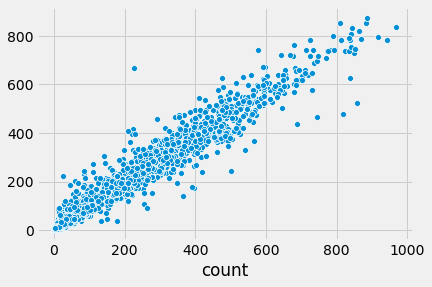

In [48]:
from scipy.stats import pearsonr
pp = pred_ad*0.7 + pred_rf5*0.3
print(pearsonr(y_val, pp))
sns.scatterplot(y_val, pp)